###  Capstone Project

by Anel Mukasheva

# THE BATTLE OF NEIGHBORHOODS

### STEP 1 - Importing libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported')

Libraries imported


### STEP 2 - Loading London Population and Average Income Data

**_Let's first load population data from website: https://www.citypopulation.de/en/uk/greaterlondon/_**

In order to obtain information from the website, we will use Beautiful Soup package. So, before we start, we need to load the library first. 

In [2]:
from bs4 import BeautifulSoup

Then, we need to obtain information from the web page and store it in soup variable

In [3]:
url = 'https://www.citypopulation.de/en/uk/greaterlondon/'
res = requests.get(url).text
soup = BeautifulSoup(res, 'lxml')

The next step will be finding necessary table on the page and obtaining information from it

In [4]:
# Finding table on the web page
my_table = soup.find('table', {'class': 'data'}, {'id': 'ts'})

In [5]:
# Obtaining information from the table
rows = []
columns = []

for index, tr in enumerate(my_table.find_all('tr')):
    data = []
    for td in tr.find_all(['th','td']):
        data.append(td.text.rstrip())
    
    if (index == 0):
        columns = data
    else:
        rows.append(data)

# Converting into Pandas DataFrame
population_df = pd.DataFrame(data = rows, columns = columns)
population_df.head(10)

,Name,Status,PopulationEstimate1981-06-30,PopulationEstimate1991-06-30,PopulationEstimate2001-06-30,PopulationEstimate2011-06-30,PopulationEstimate2018-06-30,
0,Barking and Dagenham,Borough,"161,300","155,500","165,700","187,029","211,998",→
1,Barnet,Borough,"295,200","297,700","319,500","357,538","392,140",→
2,Bexley,Borough,"217,400","218,100","218,800","232,774","247,258",→
3,Brent,Borough,"248,300","240,800","269,600","312,245","330,795",→
4,Bromley,Borough,"299,200","293,500","296,200","310,554","331,096",→
5,Camden,Borough,"179,100","180,700","202,600","220,087","262,226",→
6,City of London,City,"6,700","5,400","7,400","7,412","8,706",→
7,City of Westminster,Borough,"188,400","185,000","203,300","219,582","255,324",→
8,Croydon,Borough,"320,700","315,900","335,100","364,815","385,346",→
9,Ealing,Borough,"285,300","283,800","307,300","339,314","341,982",→


**_Now let's load average income data from excel file_**

In [6]:
income_df = pd.read_excel('https://data.london.gov.uk/download/average-income-tax-payers-borough/392e86d4-f1d3-4f06-a6a5-7fcd0fd65948/income-of-tax-payers.xlsx', sheet_name = 'Total Income')
income_df.head(10)

,Unnamed: 0,Unnamed: 1,1999-00,Unnamed: 3,Unnamed: 4,2000-01,Unnamed: 6,Unnamed: 7,2001-02,Unnamed: 9,...,Unnamed: 46,2015-16,Unnamed: 48,Unnamed: 49,2016-17,Unnamed: 51,Unnamed: 52,2017-18,Unnamed: 54,Unnamed: 55
0,Code,Area,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,...,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E09000001,City of London,10000,109800,40400,10000,137000,65000,12000,92900,...,61100,10000,142000,60000,12000,157000,57300,11000,148000,60000
3,E09000002,Barking and Dagenham,62000,16200,15100,71000,18100,15600,56000,18600,...,21800,83000,25900,22100,88000,26700,23300,85000,27400,23900
4,E09000003,Barnet,161000,26800,18700,156000,30800,19400,159000,30400,...,27100,178000,49000,27700,180000,48600,28800,188000,49500,28700
5,E09000004,Bexley,105000,20500,17200,116000,19800,17300,112000,22000,...,24400,127000,30900,24500,125000,32300,26100,122000,33500,26900
6,E09000005,Brent,122000,20000,16500,130000,22200,16800,127000,21100,...,22700,154000,32600,23200,155000,34100,24100,155000,35400,24700
7,E09000006,Bromley,163000,25100,18500,167000,26400,19500,164000,27400,...,28100,171000,43500,29800,172000,44000,30400,174000,45500,32000
8,E09000007,Camden,85000,39000,20500,107000,40000,19700,101000,42800,...,33100,103000,85000,34400,103000,88000,35500,101000,92600,37300
9,E09000008,Croydon,152000,21500,16700,162000,22100,17300,153000,23500,...,25100,178000,34200,26300,186000,33800,25600,183000,35600,27500


### STEP 3 - Cleaning and merging tables

**_1) Let's clean population_df first_**

In [7]:
population_df.columns

Index(['Name', 'Status', 'PopulationEstimate1981-06-30',
       'PopulationEstimate1991-06-30', 'PopulationEstimate2001-06-30',
       'PopulationEstimate2011-06-30', 'PopulationEstimate2018-06-30', ''],
      dtype='object')

In [8]:
population_df = population_df[['Name', 'PopulationEstimate2018-06-30']]
population_df.columns = ['Borough', 'Population']
population_df.head()

,Borough,Population
0,Barking and Dagenham,"211,998"
1,Barnet,"392,140"
2,Bexley,"247,258"
3,Brent,"330,795"
4,Bromley,"331,096"


**_2) Now let's clean income_df_**

In [9]:
# Let's remove all irrelevant columns

inc_df = income_df[['Unnamed: 1', 'Unnamed: 54']]
inc_df

,Unnamed: 1,Unnamed: 54
0,Area,Mean £
1,NaN,NaN
2,City of London,148000
3,Barking and Dagenham,27400
4,Barnet,49500
5,Bexley,33500
6,Brent,35400
7,Bromley,45500
8,Camden,92600
9,Croydon,35600


In [10]:
# Let's drop all rows after 34th row

income_df = inc_df[0:35]
income_df

# We also need to remove the 1st and 3rd rows

income_df = income_df.drop([0,1])
income_df.reset_index(drop = True, inplace = True)
income_df.head(10)

# Let's rename columns

income_df.columns = ['Borough', 'Avg_Income']
income_df.head()

,Borough,Avg_Income
0,City of London,148000
1,Barking and Dagenham,27400
2,Barnet,49500
3,Bexley,33500
4,Brent,35400


In [11]:
# Let's look at cleaned population dataframe

population_df.head()

,Borough,Population
0,Barking and Dagenham,"211,998"
1,Barnet,"392,140"
2,Bexley,"247,258"
3,Brent,"330,795"
4,Bromley,"331,096"


**_3) Now let's merge two dataframes_**

In [15]:
borough_df = pd.merge(population_df, income_df, on='Borough')
borough_df.head()

,Borough,Population,Avg_Income
0,Barking and Dagenham,"211,998",27400
1,Barnet,"392,140",49500
2,Bexley,"247,258",33500
3,Brent,"330,795",35400
4,Bromley,"331,096",45500


Let's check data types in our dataframe

In [13]:
borough_df.dtypes

Borough       object
Population    object
Avg_Income    object
dtype: object

Before we proceed with analysis we need to convert data type of Population and Avg_Income to integer

In [23]:
borough_df['Population'] = borough_df['Population'].replace(r',', '', regex=True)
borough_df.head()

,Borough,Population,Avg_Income
0,Barking and Dagenham,211998,27400
1,Barnet,392140,49500
2,Bexley,247258,33500
3,Brent,330795,35400
4,Bromley,331096,45500


In [24]:
borough_df.Population = borough_df.Population.astype('int64')
borough_df.Avg_Income = borough_df.Avg_Income.astype('int64')

In [25]:
borough_df.dtypes

Borough       object
Population     int64
Avg_Income     int64
dtype: object

In [26]:
borough_df.head(10)

,Borough,Population,Avg_Income
0,Barking and Dagenham,211998,27400
1,Barnet,392140,49500
2,Bexley,247258,33500
3,Brent,330795,35400
4,Bromley,331096,45500
5,Camden,262226,92600
6,City of London,8706,148000
7,Croydon,385346,35600
8,Ealing,341982,39700
9,Enfield,333869,36200


### STEP 3 - Finding latitude and longitude 

In order to get latitude and longitude values for all boroughs we will use GeoPy's geolocator

In [27]:
geolocator = Nominatim(user_agent="London_explorer")
borough_df['Borough_coord']= borough_df['Borough'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
borough_df[['Latitude', 'Longitude']] = borough_df['Borough_coord'].apply(pd.Series)

In [28]:
#Let's remove unnecessary column

borough_df.drop(['Borough_coord'], axis=1, inplace=True)
borough_df.head(10)

,Borough,Population,Avg_Income,Latitude,Longitude
0,Barking and Dagenham,211998,27400,51.554117,0.150504
1,Barnet,392140,49500,51.653090,-0.200226
2,Bexley,247258,33500,39.969238,-82.936864
3,Brent,330795,35400,32.937346,-87.164718
4,Bromley,331096,45500,51.402805,0.014814
5,Camden,262226,92600,39.944840,-75.119891
6,City of London,8706,148000,51.515618,-0.091998
7,Croydon,385346,35600,51.371305,-0.101957
8,Ealing,341982,39700,51.512655,-0.305195
9,Enfield,333869,36200,51.652085,-0.081018


### STEP 4 - Map of London with Boroughs

#### _1) Getting latitude and longitude for London_ 

In [29]:
address = 'London, UK'

geolocator = Nominatim(user_agent = 'London_explorer')
location = geolocator.geocode(address)
L_lat = location.latitude
L_lon = location.longitude
print("The geographical coordinate of London are {}, {}".format(L_lat, L_lon))

The geographical coordinate of London are 51.5073219, -0.1276474


#### _2) Creating a map of London with neighborhoods superimposed on it_

In [30]:
# Creating a map of Toronto using latitude and longitude values
map_london = folium.Map(location = [L_lat, L_lon], zoom_start = 10)

# Adding markers to map
for lat, lng, borough in zip (borough_df['Latitude'],
                             borough_df['Longitude'],
                             borough_df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker([lat, lng],
                       radius = 5,
                       popup = label,
                       color = 'blue',
                       fill = True,
                       fill_color = '#3186cc',
                       fill_opacity = 0.7,
                       parse_html = False).add_to(map_london)
map_london

Seems like Tower Hamlets and Havering boroughs were determined incorrectly. Let's correct their geospatial data

In [31]:
borough_df.loc[15, 'Latitude'] = 51.5779
borough_df.loc[15, 'Longitude'] = 0.2121

borough_df.loc[27, 'Latitude'] = 51.5203
borough_df.loc[27, 'Longitude'] = 0.0293

Let's create new map with correct data

In [32]:
# Creating a map of Toronto using latitude and longitude values
map_london = folium.Map(location = [L_lat, L_lon], zoom_start = 10)

# Adding markers to map
for lat, lng, borough in zip (borough_df['Latitude'],
                             borough_df['Longitude'],
                             borough_df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker([lat, lng],
                       radius = 5,
                       popup = label,
                       color = 'blue',
                       fill = True,
                       fill_color = '#3186cc',
                       fill_opacity = 0.7,
                       parse_html = False).add_to(map_london)
map_london

Now, everything seems to be correct.

### STEP 5 - Borough Analysis

#### **_Since we investigate three criteria which can influence business opening location, namely borough population, borough average income and number of competitors, we need to decide which criterion is the most important and which is the least. Let's assume that we want to start medium size aisan cuisine restaurant, not iferior, but not super luxurious. Thus, we are more interested in high foot traffic and in higher borough population respectively_**

### Analysis algorithm:

1. Find top 15 most populated boroughs in London;
2. Find top 5 richest boroughs among 15 most populated ones from point 1; 
3. Find top 100 popular venues for each borough from point 2;
4. Find borough where the number of asian cuisine restaurants is the lowest; 

#### 5.1) Find top 15 most populated boroughs in London;

In [33]:
# Let's create new dataframe with boroughs and population only
borough_by_population = borough_df[['Borough','Population']]
borough_by_population.head(10)

# Let's sort data
borough_by_population.sort_values(by=['Population'], inplace=True, ascending=False)
borough_by_population.reset_index(drop = True, inplace = True)
top_pop = borough_by_population.head(15)
top_pop

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Borough,Population
0,Barnet,392140
1,Croydon,385346
2,Newham,352005
3,Ealing,341982
4,Enfield,333869
5,Bromley,331096
6,Brent,330795
7,Wandsworth,326474
8,Lambeth,325917
9,Tower Hamlets,317705


Let's visualize obtained data

In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt

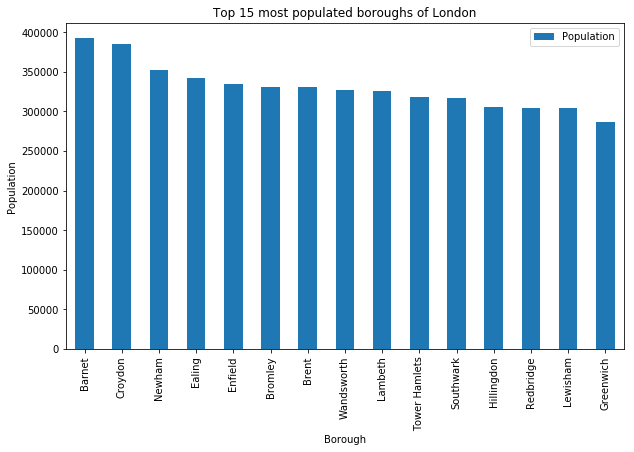

In [35]:
top_pop.plot(kind = 'bar', x='Borough', figsize = (10,6))
plt.title('Top 15 most populated boroughs of London')
plt.ylabel('Population')
plt.xlabel('Borough')
plt.show()

#### 5.2) Find top 5 richest boroughs among 15 most populated ones in London;

In [36]:
borough_by_income = pd.merge(top_pop, borough_df, on='Borough')

borough_by_income.sort_values(by=['Avg_Income'], inplace=True, ascending=False)
borough_by_income.reset_index(drop = True, inplace = True)
top_income = borough_by_income.head(5)
top_income.head()

,Borough,Population_x,Population_y,Avg_Income,Latitude,Longitude
0,Wandsworth,326474,326474,67900,51.457027,-0.193261
1,Barnet,392140,392140,49500,51.653090,-0.200226
2,Southwark,317256,317256,48600,51.502922,-0.103458
3,Tower Hamlets,317705,317705,46600,51.520300,0.029300
4,Lambeth,325917,325917,45600,51.501301,-0.117287


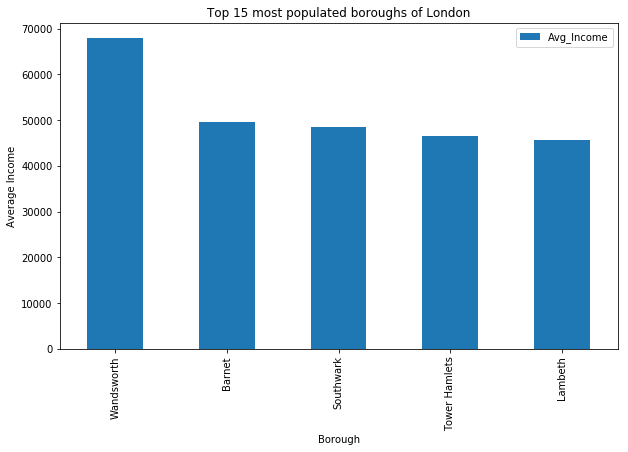

In [53]:
# Visualization
subset = top_income[['Borough', 'Avg_Income']]
subset.plot(kind = 'bar', x='Borough', figsize = (10,6))
plt.title('Top 15 most populated boroughs of London')
plt.ylabel('Average Income')
plt.xlabel('Borough')
plt.show()

**_Thus, we will make contractors investigation for 1. Wandsworth, 2. Barnet, 3. Southwark, 4. Tower Hamlets and 5. Lambeth boroughs_**

#### 5.3) Find top 100 popular venues for each borough from point 2;

#### 5.3.1) Define Foursquare credentials and version

In [37]:
CLIENT_ID = '2FGOX3GRP4IDSY0HBAOJR1HTCWP0RVNFK0ZBIM22MNUWRKBJ'
CLIENT_SECRET = 'PUK3ZBTS3QG1EIKNRWSFSAKVO2OAQCUYJYV30C4MDCKMZHR2'
VERSION = '20200503'

Let's explore the 1st neighborhood in top_income dataframe

In [38]:
neighborhood_latitude = top_income.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = top_income.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = top_income.loc[0, 'Borough'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wandsworth are 51.4570271, -0.1932607.


In [39]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url 


'https://api.foursquare.com/v2/venues/explore?&client_id=2FGOX3GRP4IDSY0HBAOJR1HTCWP0RVNFK0ZBIM22MNUWRKBJ&client_secret=PUK3ZBTS3QG1EIKNRWSFSAKVO2OAQCUYJYV30C4MDCKMZHR2&v=20200503&ll=51.4570271,-0.1932607&radius=500&limit=100'

In [40]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eaec90983525f001be88037'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Wandsworth',
  'headerFullLocation': 'Wandsworth, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 37,
  'suggestedBounds': {'ne': {'lat': 51.4615271045,
    'lng': -0.18605223883324373},
   'sw': {'lat': 51.452527095499995, 'lng': -0.20046916116675628}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b215bd7f964a520b03a24e3',
       'name': "King's Arms",
       'location': {'address': '94-96 Wandsworth High Street',
        'lat': 51.457344,
        'lng': -0.194708,
        'labeledLatLngs': [{'label': 'display',
          'lat': 51.457344,


In [41]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [42]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,King's Arms,Pub,51.457344,-0.194708
1,easyGym,Gym / Fitness Center,51.456063,-0.193755
2,Cafe Fleur,Café,51.455728,-0.188987
3,Waterstones,Bookstore,51.454667,-0.192974
4,Brewers Inn,Pub,51.456780,-0.189565


#### 5.3.2) Let's get 100 venues that are in our boroughs

In [43]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [44]:
london_venues = getNearbyVenues(names=top_income['Borough'],
                                   latitudes=top_income['Latitude'],
                                   longitudes=top_income['Longitude']
                                  )

Wandsworth
Barnet
Southwark
Tower Hamlets
Lambeth


In [45]:
london_venues.head(10)

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wandsworth,51.457027,-0.193261,King's Arms,51.457344,-0.194708,Pub
1,Wandsworth,51.457027,-0.193261,easyGym,51.456063,-0.193755,Gym / Fitness Center
2,Wandsworth,51.457027,-0.193261,Cafe Fleur,51.455728,-0.188987,Café
3,Wandsworth,51.457027,-0.193261,Waterstones,51.454667,-0.192974,Bookstore
4,Wandsworth,51.457027,-0.193261,Brewers Inn,51.456780,-0.189565,Pub
5,Wandsworth,51.457027,-0.193261,Ekachai,51.454105,-0.193039,Asian Restaurant
6,Wandsworth,51.457027,-0.193261,The Grapes,51.458719,-0.190589,Pub
7,Wandsworth,51.457027,-0.193261,The Black Chapel,51.456831,-0.194796,Coffee Shop
8,Wandsworth,51.457027,-0.193261,Rossopomodoro,51.455410,-0.192717,Pizza Place
9,Wandsworth,51.457027,-0.193261,Planet Organic,51.454964,-0.192826,Organic Grocery


In [46]:
london_restaurants = london_venues[london_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
london_restaurants

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wandsworth,51.457027,-0.193261,Ekachai,51.454105,-0.193039,Asian Restaurant
1,Wandsworth,51.457027,-0.193261,Nando's,51.454453,-0.193179,Portuguese Restaurant
2,Wandsworth,51.457027,-0.193261,Konnigans,51.460159,-0.188620,Restaurant
3,Wandsworth,51.457027,-0.193261,wagamama,51.455429,-0.192918,Asian Restaurant
4,Wandsworth,51.457027,-0.193261,The Thai,51.459859,-0.189345,Thai Restaurant
5,Barnet,51.653090,-0.200226,Spizzico,51.656600,-0.201802,Italian Restaurant
6,Barnet,51.653090,-0.200226,Dudley's Pancake House,51.652965,-0.199625,Restaurant
7,Barnet,51.653090,-0.200226,Carluccio's,51.655254,-0.201862,Italian Restaurant
8,Barnet,51.653090,-0.200226,KFC,51.655905,-0.202105,Fast Food Restaurant
9,Barnet,51.653090,-0.200226,Shapla Indian Restaurant Barnet,51.652833,-0.199662,Indian Restaurant


In [47]:
bb = london_restaurants['Borough'].unique()
bb

array(['Wandsworth', 'Barnet', 'Southwark', 'Tower Hamlets', 'Lambeth'],
      dtype=object)

In [48]:
map_restaurants = folium.Map(location=[L_lat, L_lon], zoom_start=10)

# set color scheme for the Venues based on the Major Districts
Boroughs = ['Wandsworth', 'Barnet', 'Southwark', 'Tower Hamlets', 'Lambeth']

x = np.arange(len(Boroughs))

rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000']

# add markers to the map
# markers_colors = []
for lat, lon, poi, distr in zip(london_restaurants['Venue Latitude'], 
                                  london_restaurants['Venue Longitude'], 
                                  london_restaurants['Venue Category'], 
                                  london_restaurants['Borough']):
    label = folium.Popup(str(poi) + ' ' + str(distr), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[Boroughs.index(distr)-1],
        fill=True,
        fill_color=rainbow[Boroughs.index(distr)-1],
        fill_opacity=0.3).add_to(map_restaurants)
    
map_restaurants

In [49]:
### Number of Unique Categories in the Dataframe 
print('There are {} unique categories.'.format(len(london_restaurants['Venue Category'].unique())))

There are 26 unique categories.


In [89]:
print (london_restaurants['Venue Category'].value_counts())

Italian Restaurant               7
Restaurant                       7
Chinese Restaurant               4
Korean Restaurant                3
Asian Restaurant                 3
Ramen Restaurant                 2
Modern European Restaurant       2
Thai Restaurant                  2
English Restaurant               2
Turkish Restaurant               2
Fast Food Restaurant             2
Indian Restaurant                2
Vietnamese Restaurant            2
Mexican Restaurant               1
Dim Sum Restaurant               1
Latin American Restaurant        1
Spanish Restaurant               1
Vegetarian / Vegan Restaurant    1
Israeli Restaurant               1
Tapas Restaurant                 1
Argentinian Restaurant           1
Sushi Restaurant                 1
Eastern European Restaurant      1
Japanese Restaurant              1
French Restaurant                1
Portuguese Restaurant            1
Name: Venue Category, dtype: int64


In [50]:
asian_restaurants = london_restaurants[london_restaurants['Venue Category'].str.contains('Asian Restaurant')]
chinese_restaurants = london_restaurants[london_restaurants['Venue Category'].str.contains('Chinese Restaurant')]
korean_restaurants = london_restaurants[london_restaurants['Venue Category'].str.contains('Korean Restaurant')]
ramen_restaurants = london_restaurants[london_restaurants['Venue Category'].str.contains('Ramen Restaurant')]
jap_restaurants = london_restaurants[london_restaurants['Venue Category'].str.contains('Japanese Restaurant')]
sushi_restaurant = london_restaurants[london_restaurants['Venue Category'].str.contains('Sushi Restaurant')]

rests = pd.concat([asian_restaurants, chinese_restaurants, korean_restaurants, ramen_restaurants, sushi_restaurant, jap_restaurants])
rests

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wandsworth,51.457027,-0.193261,Ekachai,51.454105,-0.193039,Asian Restaurant
3,Wandsworth,51.457027,-0.193261,wagamama,51.455429,-0.192918,Asian Restaurant
31,Southwark,51.502922,-0.103458,wagamama,51.506428,-0.100118,Asian Restaurant
11,Barnet,51.653090,-0.200226,From China,51.651168,-0.196508,Chinese Restaurant
26,Southwark,51.502922,-0.103458,Lin's Restaurant & Bar,51.506318,-0.102086,Chinese Restaurant
39,Southwark,51.502922,-0.103458,Chinese Canteen,51.500599,-0.108020,Chinese Restaurant
45,Lambeth,51.501301,-0.117287,Zen China Restaurant,51.502059,-0.119769,Chinese Restaurant
34,Southwark,51.502922,-0.103458,oseyo eats Waterloo,51.502285,-0.110267,Korean Restaurant
43,Lambeth,51.501301,-0.117287,Po Cha,51.501035,-0.112213,Korean Restaurant
48,Lambeth,51.501301,-0.117287,KORRITO,51.505450,-0.116296,Korean Restaurant


In [51]:
print (rests['Borough'].value_counts())

Southwark     7
Lambeth       4
Wandsworth    2
Barnet        1
Name: Borough, dtype: int64
